## Sieci neuronowe

## Neuron
Konstrukcja pojedynczego neuronu jest bardzo prosta. Inputami do neuronu są wartości z innych nauronów lub zmiennych źródłowych, które układane są w równanie liniowe z odpowiednimi wagami. Właśnie ta suma elementów stanowi argument funkcji aktywacji, która jest wywoływana w neuronie.
<img src="img/neuron_model.jpg">
Źródło: https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/neural_networks.html

## Sieć neuronowa i jej typy
Sieci neuronowe polegają na złączeniu wielu neuronów. Zwykle sieci układa się w warstwy tak aby wyniki z kolejnych grup neuronów stanowiły input dla kolejnej grupy. Dzięki temu możliwa jest aproksymacja dowolnej funkcji.
<img src="img/network.png">
Źródło: http://neuralnetworksanddeeplearning.com/chap1.html

Neurony można ze sobą łączyć na bardzo wiele sposobów. Od najprostszych, gdzie dysponujemy tylko jednym neuronem, a w zależności od funkcji aktywacji (i funkcji straty) sieć neuronowa redukuje się do regresji liniowej lub logistycznej. 

W praktyce istnieje nieskończenie wiele sposobów na łączenie neuronów. Podstawowe typy przedstawia poniższy diagram.

<img src="img/neuralnetworks.png">
Źródło: https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/neural_networks.html


In [9]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing.text import Tokenizer
from keras.layers.advanced_activations import PReLU


from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

import time
%matplotlib inline

import gc


In [10]:
medical = pd.read_pickle("datasets/medical.p")
print(medical.UCURNINS.unique())
medical["UCURNINS"] = (medical.UCURNINS=="Yes").astype(int)
print(medical.UCURNINS.unique())

levCols = ["UMARSTAT", "USATMED", "URELATE",
                      "REGION", "FHOSP", "UIMMSTAT",
                      "U_FTPT", "UBRACE", "UEDUC3",
                      "GENDER"]

numCols = ["FDENT", "FEMER", "FDOCT", "UAGE",
                     "U_WKSLY", "U_USHRS", "U_HRSLY",
                     "HOTHVAL", "HRETVAL", "HSSVAL", "HWSVAL"]
# Binaryzacja zmiennych nominalnych
dummLev = pd.get_dummies(medical[levCols], drop_first=True)
medical2 = pd.concat([medical[numCols], dummLev], axis=1)
features = medical2.columns.tolist()
medical2["UCURNINS"] = medical["UCURNINS"]
medical = medical2
medical[numCols] = medical[numCols].apply(lambda x: (x-x.mean())/x.std())


['Yes' 'No']
[1 0]


In [11]:
medical.head()

FDENT     FEMER     FDOCT      UAGE   U_WKSLY   U_USHRS   U_HRSLY  \
0 -1.039196 -0.416196 -0.671216 -1.542607  0.497789 -0.122943 -0.096572   
1  0.286934 -0.416196 -0.671216 -0.834812  0.497789 -0.122943 -0.096572   
2 -1.039196  0.840202 -0.671216 -0.569388  0.497789 -0.875098 -0.856802   
3 -1.039196 -0.416196 -0.398506  0.138408 -0.416425 -1.251175 -0.096572   
4  0.286934 -0.416196 -0.671216 -0.480914  0.497789 -0.122943 -0.096572   

    HOTHVAL   HRETVAL    HSSVAL    ...     REGION_West  FHOSP_Yes  \
0 -0.451826 -0.202876 -0.405634    ...               0          0   
1 -0.094459 -0.202876 -0.405634    ...               0          0   
2  0.229274 -0.202876  0.454197    ...               0          0   
3  1.890703 -0.202876 -0.405634    ...               0          0   
4 -0.199567 -0.202876 -0.405634    ...               0          0   

   UIMMSTAT_Foreign-born, non-citizen  UIMMSTAT_US-born citizen  \
0                                   0                         1   
1                                   0                         1   
2                                   0                         1   
3                                   0                         1   
4                                   0                         1   

   U_FTPT_Part-time  UBRACE_Asian/Pacific Islander  UBRACE_Black  \
0                 0                              0             0   
1                 0                              0             0   
2                 1                              0             0   
3                 1                              0             1   
4                 0                              0             1   

   UBRACE_White  GENDER_Male  UCURNINS  
0             1            0         1  
1             1            0         0  
2             1            1         0  
3             0            0         1  
4             0            1         0  

[5 rows x 33 columns]

medical.head()

In [12]:
medical.shape

(35072, 33)

In [13]:
def actModel(model, activation):
    if activation=='prelu':
        model.add(keras.layers.advanced_activations.PReLU(weights=None, alpha_initializer="zero"))
    else:
        model.add(Activation(activation))
    return

def create_network(n=3, nu=[160, 160, 160],
                   activation='selu',
                   dropout=Dropout,
                   dropout_rate=0.1,
                   regu=0.1,
                   kernel_initializer='lecun_normal',
                   optimizer='adam',
                   num_classes=1, 
                  inputShape=10, verb=False):
    if verb:
        print(locals())
    model = Sequential()
    model.add(Dense(nu[0],input_shape=(inputShape,),
                    kernel_initializer=kernel_initializer, kernel_regularizer=regularizers.l2(regu)))
    actModel(model, activation)
    if dropout_rate > 0.01:
        model.add(dropout(dropout_rate))

    for i in range(1, n):
        model.add(Dense(nu[i], kernel_initializer=kernel_initializer))
        actModel(model, activation)
        if dropout_rate > 0.01:
            model.add(dropout(dropout_rate))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [14]:
from sklearn.metrics import roc_auc_score
def net(train, test, features, target, network, epochs = 30, batchSize=100, verb=False):
    y_train = pd.get_dummies(train[target]).values
    y_test = pd.get_dummies(test[target]).values
    x_train = train[features].values
    x_test = test[features].values
    
    num_classes = y_train.shape[1]
    
    if verb:
        print('Loading data...')
        print(len(x_train), 'train sequences')
        print(len(x_test), 'test sequences')
        print(num_classes, 'classes')
        print('x_train shape:', x_train.shape)
        print('x_test shape:', x_test.shape)
        print('\nBuilding network 1...')

    network["verb"] = verb
    model = create_network(num_classes=num_classes, inputShape=x_train.shape[1], **network)
    history_model = dict()
    loss = []
    valLoss = []
    acc = []
    valAcc = []
    auc = []
    valAuc = []
    for z in range(epochs):
        histModel = model.fit(x_train,
                                    y_train,
                                    batch_size=batchSize,
                                    epochs=1,
                                    verbose=verb,
                                    validation_split=0.0,
                                   validation_data=(x_test, y_test))

        probaTrain = model.predict(x_train,
                                       batch_size=y_train.shape[0],
                                       verbose=verb)
        probaTest = model.predict(x_test,
                                       batch_size=y_test.shape[0],
                                       verbose=verb)
        aucTrain = roc_auc_score(train[target], probaTrain[:,1])
        aucTest = roc_auc_score(test[target], probaTest[:,1])
        if verb:
            print(aucTrain, aucTest)
        loss.append(histModel.history['loss'][0])
        valLoss.append(histModel.history['val_loss'][0])
        acc.append(histModel.history['acc'][0])
        valAcc.append(histModel.history['val_acc'][0])
        auc.append(aucTrain)
        valAuc.append(aucTest)
    history_model['loss'] = loss
    history_model['valLoss'] = valLoss
    history_model['acc'] = acc
    history_model['valAcc'] = valAcc
    history_model['auc'] = auc
    history_model['valAuc'] = valAuc
    return max(valAuc), history_model


In [15]:
def wrapNet(X_train, X_valid, selFeat, target, n=3, nu1=1000, nu2=300, nu3=100, epochs = 30, batchSize=50,
            dropout_rate=0, regu=0.00, optimizer = "SGD", activation="relu", verb=False):
    network =  {
    'n':int(n),
    'nu': [nu1, nu2, nu3],
    'activation': activation,
    'dropout': Dropout,
    'regu':regu,
    'dropout_rate': dropout_rate,
    'kernel_initializer': 'RandomNormal',
    'optimizer': optimizer
    }

    score, history = net(X_train, X_valid, selFeat, target, network, epochs = epochs, batchSize=batchSize, verb=verb)
    gc.collect()
    return score, history

def netFold(dataset, selFeat, target, n=2, nu1=600, nu2=100, nu3=20, epochs = 30, batchSize=100,
            dropout_rate=0, regu=0.00, optimizer = "SGD", activation="relu", verb=False):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2017)
    scores=[]
    for train_index, test_index in kf.split(dataset[selFeat], dataset[target]):
        score, history = wrapNet(dataset.iloc[train_index], dataset.iloc[test_index], selFeat, target,
                                 n=n, nu1=nu1, nu2=nu2, nu3=nu3, dropout_rate=dropout_rate, optimizer=optimizer, regu=regu, activation=activation)
        scores.append(score)
    print(scores)
    return np.mean(scores)


Loading data...
24550 train sequences
10522 test sequences
2 classes
x_train shape: (24550, 32)
x_test shape: (10522, 32)

Building network 1...
{'kernel_initializer': 'RandomNormal', 'dropout_rate': 0, 'num_classes': 2, 'nu': [100, 40, 6], 'dropout': <class 'keras.layers.core.Dropout'>, 'inputShape': 32, 'optimizer': 'SGD', 'n': 2, 'activation': 'relu', 'verb': True, 'regu': 0.0}
Train on 24550 samples, validate on 10522 samples
Epoch 1/1
10522/10522 [==============================] - 0s 3us/step
0.6070694320518866 0.6093185067061121
Train on 24550 samples, validate on 10522 samples
Epoch 1/1
10522/10522 [==============================] - 0s 2us/step
0.6300243229796533 0.6309268992855388
Train on 24550 samples, validate on 10522 samples
Epoch 1/1
10522/10522 [==============================] - 0s 2us/step
0.6516836746805029 0.6520638688478584
Train on 24550 samples, validate on 10522 samples
Epoch 1/1
10522/10522 [==============================] - 0s 2us/step
0.6730325075458998 0.67291

10522/10522 [==============================] - 0s 2us/step
0.8071593714107903 0.8031839415802338
Train on 24550 samples, validate on 10522 samples
Epoch 1/1
10522/10522 [==============================] - 0s 2us/step
0.8083098854857823 0.8041809787883394
Train on 24550 samples, validate on 10522 samples
Epoch 1/1
10522/10522 [==============================] - 0s 2us/step
0.8093782703329518 0.8051154567990739
Train on 24550 samples, validate on 10522 samples
Epoch 1/1
10522/10522 [==============================] - 0s 2us/step
0.8103597595838378 0.8059803961692723
Train on 24550 samples, validate on 10522 samples
Epoch 1/1
10522/10522 [==============================] - 0s 2us/step
0.8112941759112733 0.8067601936411792
Train on 24550 samples, validate on 10522 samples
Epoch 1/1
10522/10522 [==============================] - 0s 2us/step
0.8121423679619266 0.8075016955296483
Train on 24550 samples, validate on 10522 samples
Epoch 1/1
10522/10522 [==============================] - 0s 2us/step

10522/10522 [==============================] - 0s 2us/step
0.8225275531005669 0.816798752324045
Train on 24550 samples, validate on 10522 samples
Epoch 1/1
10522/10522 [==============================] - 0s 2us/step
0.8228663210606462 0.8170948853471158
Train on 24550 samples, validate on 10522 samples
Epoch 1/1
10522/10522 [==============================] - 0s 2us/step
0.8231487384617631 0.8173382523181983
Train on 24550 samples, validate on 10522 samples
Epoch 1/1
10522/10522 [==============================] - 0s 2us/step
0.8234968780420843 0.8176786737450157
Train on 24550 samples, validate on 10522 samples
Epoch 1/1
10522/10522 [==============================] - 0s 2us/step
0.8237686953082715 0.8179201040119739
Train on 24550 samples, validate on 10522 samples
Epoch 1/1
10522/10522 [==============================] - 0s 2us/step
0.824112229636812 0.8182379792794584
Train on 24550 samples, validate on 10522 samples
Epoch 1/1
10522/10522 [==============================] - 0s 2us/step
0

10522/10522 [==============================] - 0s 2us/step
0.8288961598161465 0.8229042668880601
Train on 24550 samples, validate on 10522 samples
Epoch 1/1
10522/10522 [==============================] - 0s 2us/step
0.8290136138761418 0.8229921859469824
Train on 24550 samples, validate on 10522 samples
Epoch 1/1
10522/10522 [==============================] - 0s 3us/step
0.8292620356576992 0.823244469065354
Train on 24550 samples, validate on 10522 samples
Epoch 1/1
10522/10522 [==============================] - 0s 2us/step
0.8295064630882222 0.8235137805633835
Train on 24550 samples, validate on 10522 samples
Epoch 1/1
10522/10522 [==============================] - 0s 2us/step
0.8296985410240125 0.8236996310761351
Train on 24550 samples, validate on 10522 samples
Epoch 1/1
10522/10522 [==============================] - 0s 2us/step
0.8298998361765594 0.8238935938212562
Train on 24550 samples, validate on 10522 samples
Epoch 1/1
10522/10522 [==============================] - 0s 2us/step


10522/10522 [==============================] - 0s 2us/step
0.8330507615287309 0.8268214519580444
Train on 24550 samples, validate on 10522 samples
Epoch 1/1
10522/10522 [==============================] - 0s 2us/step
0.8331933027985 0.8269533670880156
Train on 24550 samples, validate on 10522 samples
Epoch 1/1
10522/10522 [==============================] - 0s 2us/step
0.8333439737474333 0.8270858668833825
Train on 24550 samples, validate on 10522 samples
Epoch 1/1
10522/10522 [==============================] - 0s 2us/step
0.8334352262072823 0.8271406792642572
Train on 24550 samples, validate on 10522 samples
Epoch 1/1
10522/10522 [==============================] - 0s 2us/step
0.8336257064026588 0.8273401963306399
0.8273401963306399
0.8273401963306399


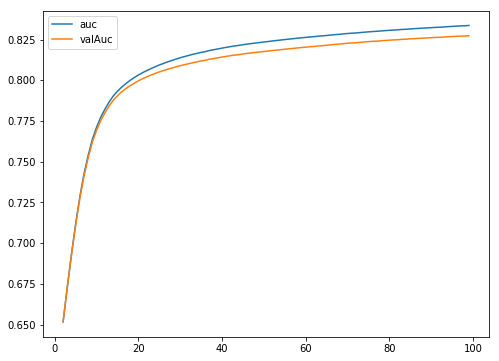

In [16]:
test_size=0.3
X_train, X_valid = train_test_split(medical, test_size=test_size, random_state=2017, stratify=medical["UCURNINS"].values)
score, history = wrapNet(X_train, X_valid, features, 'UCURNINS', n=2, nu1=100, nu2=40, nu3=6, epochs = 100, batchSize=1000, verb=True)
print(score)
history = pd.DataFrame(history)
print(history.valAuc.max())
history.iloc[2:, [1,4]].plot(figsize=(8,6))
plt.show()

## Optymalizacja, czy to musi trwać wieczność?

### Stochastic gradient descent (SGD)
$$\theta = \theta - \eta \cdot \nabla_\theta J( \theta; x^{(i)}; y^{(i)})$$
Tradycyjne podejści gradientowe nakazuje nam policzyć gradient, a następnie wykonać krok w stronę wskazaną przez ten gradient. Nazwa stochastich pochodzi stąd, że za kazdym razem losujemy kolejność naszych obserwacji przy liczeniu gradientyu. Rozwiązanie to jest często stosowane w podejściu batchowym. W tej sytuacji nie tylko permutujemy nasze obserwacje, ale również bierzemy tylko ich małą część. 

Kluczowym parametrem jest *learning rate* $\eta$ (tempo uczenia), które wyznacza nam szybkość z jaką aktualizujemy gradient korzystając z nowych informacji.

SGD jest podejściem bardzo bezpiecznym, skutecznym, ale niestety powolnym. Konwergencja następuje zwykle bardzo powoli.

#### Momentum
Rozwiązaniem powolności SGD jest zastosowanie *momentum* $\gamma$ (rozpędu). W tym przypadku zakładamy, że nasza kolejna aktualizacja gradientu będzie podobna do poprzedniej i jedynie zaktualizowana o nowy gradient.
$$
\begin{align}
\begin{split}
v_t &= \gamma v_{t-1} + \eta \nabla_\theta J( \theta) \\  
\theta &= \theta - v_t
\end{split}
\end{align}
$$

#### Nesterov momentum, Nesterov accelerated gradient (NAG)
Podstawowe podejście momentum powoduje, że kolejna aktualizacja gradientu jest wypadkową rozpędu i nowych informacji. W wersji Nestorova najpierw robimy krok wynikający z rozpędu, a nastepnie korygujemi kierunek robiąc aktualizację już z nowego punktu.
$$\begin{align}
\begin{split}
v_t &= \gamma v_{t-1} + \eta \nabla_\theta J( \theta - \gamma v_{t-1} ) \\  
\theta &= \theta - v_t
\end{split}
\end{align}
$$
<img src="img/nesterov.jpeg" width="80%">
http://cs231n.github.io/neural-networks-3/

#### Adaptive Gradient Algorithm (AdaGrad)
Jak sama nazwa wskazuje jest to algorytm, w którym learning rate jest dostosowywany w trakcie szkolenia. Sposób aktualizacji $\eta$ jest jednak bardzo prosty. Aktualizacja $\eta$ przebiega w oparciu o wielkości wszystkich dotychczasowych gradientów. W rezultacje wcześniejsze gradienty szybko się akumulują co powoduje, że bardzo szybko spada do niskich wartości (zwykle zbyt szybko). 

#### Root Mean Square Propagation (RMSProp)
Rozwiązaniem problemu AdaGrad ma być RMSProp. Podobnie jak wczesniej $\eta$ jest aktualizowana w oparciu o wczesniejsze gradienty, tylko tym razem są one stopniowo wygaszane (tak jak w średniej wykładniczej). Dzięki temu zabiegowi wielkość ta nie rośnie tak szybko, a w konsekwencji learnign rate spada wolniej, w bardziej odpowiednim tempie.

#### Adam
Ostatni, dyskusyjnie uważanym za najlepsze, rozwiązaniem jest Adam. W tym podejściu równoważą się dwie siły z jednej strony akumulujemy wcześniejsze gradienty aby rozpędzać naszą zmianę, a z drugiej akumulacja kwadratów gradientów odpowiada za ich spowalanianie.
$$\begin{align}
\begin{split}
m_t &= \beta_1 m_{t-1} + (1 - \beta_1) g_t \\  
v_t &= \beta_2 v_{t-1} + (1 - \beta_2) g_t^2  
\end{split}
\end{align}
$$

$$\theta_{t+1} = \theta_{t} - \dfrac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t$$
Autorzy tego pomysłu zauważają jednak, że tak skonstruowane wartości m i v charakteryzują się pewnym obciążeniem, z tego powodu zaproponowali następującą korektę.
$$\begin{align}
\begin{split}
\hat{m}_t &= \dfrac{m_t}{1 - \beta^t_1} \\
\hat{v}_t &= \dfrac{v_t}{1 - \beta^t_2} \end{split}
\end{align}$$

Co to wszystko oznacza dla nas w praktyce? Otóż możemy rozpocząć od Adama i na nim skończyć jeżeli nasze wyniki są dobre. Z innymi optymalizatorami eksperymentować w razie potrzeby i posiadanego czasu. Poniższa animacja doskonale ilustruje różnice w zachowaniu i sposobie działania poszczególnych optymalizatorów.

<img src="img/contours_evaluation_optimizers.gif" width="50%">
Źródło: http://ruder.io/optimizing-gradient-descent/index.html#visualizationofalgorithms


Do poczytania:
* https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/
* http://ruder.io/optimizing-gradient-descent/index.html#visualizationofalgorithms
* http://cs231n.github.io/neural-networks-3/

0.8420909753972801
0.8425202659642886
0.8426339468422223
0.8436223236941499
0.8438516952373156
0.8443124481109461


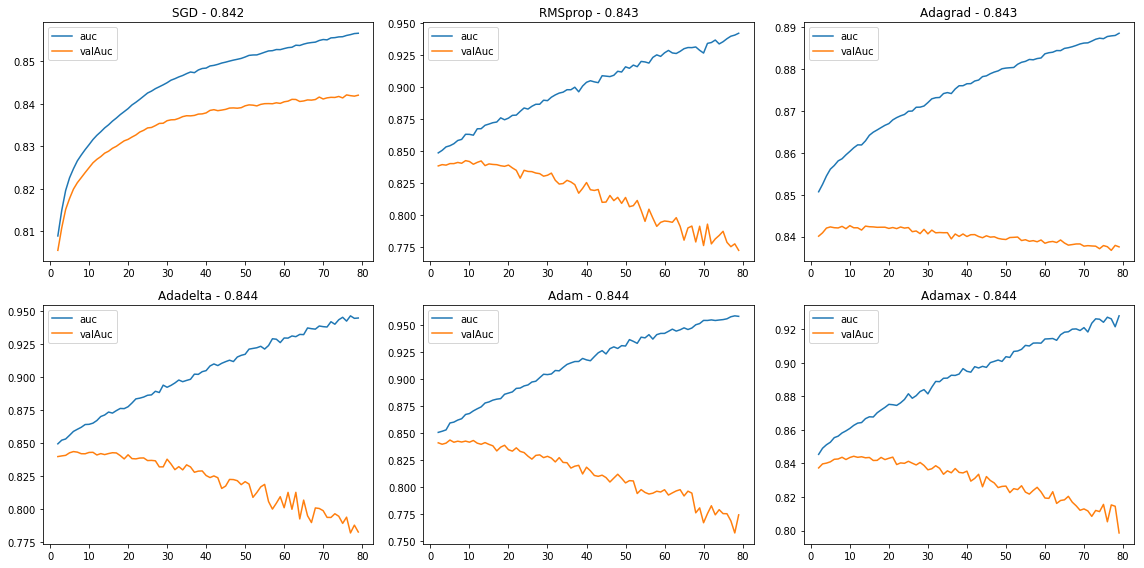

In [17]:
opti = ["SGD", "RMSprop", "Adagrad", "Adadelta", "Adam", "Adamax"]
test_size=0.3
X_train, X_valid = train_test_split(medical, test_size=test_size, random_state=2017, stratify=medical["UCURNINS"].values)
fig, ax = plt.subplots(2, 3, figsize=(16,8))
ax = ax.flatten()

for i, opt in enumerate(opti):
    score, history = wrapNet(X_train, X_valid, features, 'UCURNINS', n=2, nu1=100, nu2=40, nu3=6, epochs = 80, batchSize=100, optimizer=opt, verb=False)
    print(score)
    history = pd.DataFrame(history)
    history.iloc[2:, [1,4]].plot(ax = ax[i])
    ax[i].set_title(opt+ " - " + str(round(score, 3)))
    gc.collect()

plt.tight_layout()
fig.savefig("imgNets/opti_2_100_40.png")
plt.show()

0.8447257334627393
0.8414747015283153
0.8452873776587659
0.8454050050281225
0.8465315456214408
0.8438995647166128


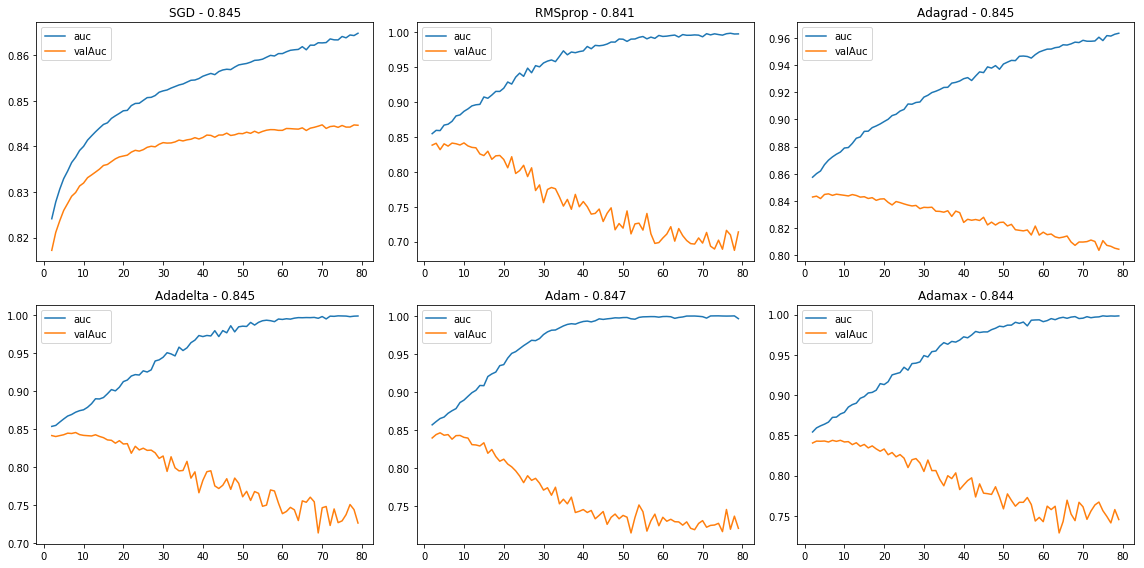

In [18]:
opti = ["SGD", "RMSprop", "Adagrad", "Adadelta", "Adam", "Adamax"]
test_size=0.3
X_train, X_valid = train_test_split(medical, test_size=test_size, random_state=2017, stratify=medical["UCURNINS"].values)
fig, ax = plt.subplots(2, 3, figsize=(16,8))
ax = ax.flatten()

for i, opt in enumerate(opti):
    score, history = wrapNet(X_train, X_valid, features, 'UCURNINS', n=2, nu1=400, nu2=100, nu3=6, epochs = 80, batchSize=100, optimizer=opt, verb=False)
    print(score)
    history = pd.DataFrame(history)
    history.iloc[2:, [1,4]].plot(ax = ax[i])
    ax[i].set_title(opt+ " - " + str(round(score, 3)))
    gc.collect()

plt.tight_layout()
fig.savefig("imgNets/opti_2_400_100.png")
plt.show()

0.8442992200563617
0.8431287930167565
0.8440882289315825
0.8447284740817831
0.8444897478922813
0.845904565067412


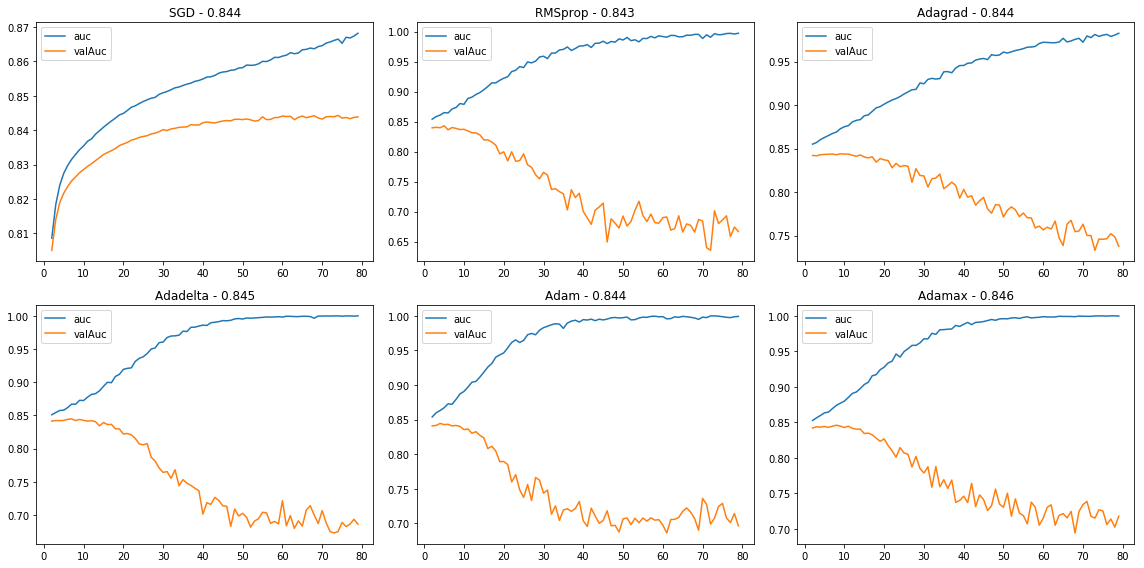

In [19]:
opti = ["SGD", "RMSprop", "Adagrad", "Adadelta", "Adam", "Adamax"]
test_size=0.3
X_train, X_valid = train_test_split(medical, test_size=test_size, random_state=2017, stratify=medical["UCURNINS"].values)
fig, ax = plt.subplots(2, 3, figsize=(16,8))
ax = ax.flatten()

for i, opt in enumerate(opti):
    score, history = wrapNet(X_train, X_valid, features, 'UCURNINS', n=3, nu1=400, nu2=100, nu3=30, epochs = 80, batchSize=100, optimizer=opt, verb=False)
    print(score)
    history = pd.DataFrame(history)
    history.iloc[2:, [1,4]].plot(ax = ax[i])
    ax[i].set_title(opt+ " - " + str(round(score, 3)))
    gc.collect()

plt.tight_layout()
fig.savefig("imgNets/opti_3_400_100_30.png")
plt.show()

Zachowanie optymalizatorów możemy dalej kontrolować poprzez learning rate. Zmniejszająć learning rate spowodujemy, że zmiany sieci będą postępowały wolniej. W większości przypadków ręczna zmiana learning rate nie będzie potrzebna.

## Batch size
Kiedy wykorzystujemy SGD dwa najważniejsze parametry to Batch size i learning rate. Kiedy korzystamy z innych optymalizatorów, np Adama jedynym parametrem, który powinniśmy ustawić jest w zasadzie batch size.

0.8440101395596299
0.8437330447035161
0.8393167380932892
0.83076545855307
0.8447214215554439
0.8454328131760195
0.8435268405266667
0.843007219155977


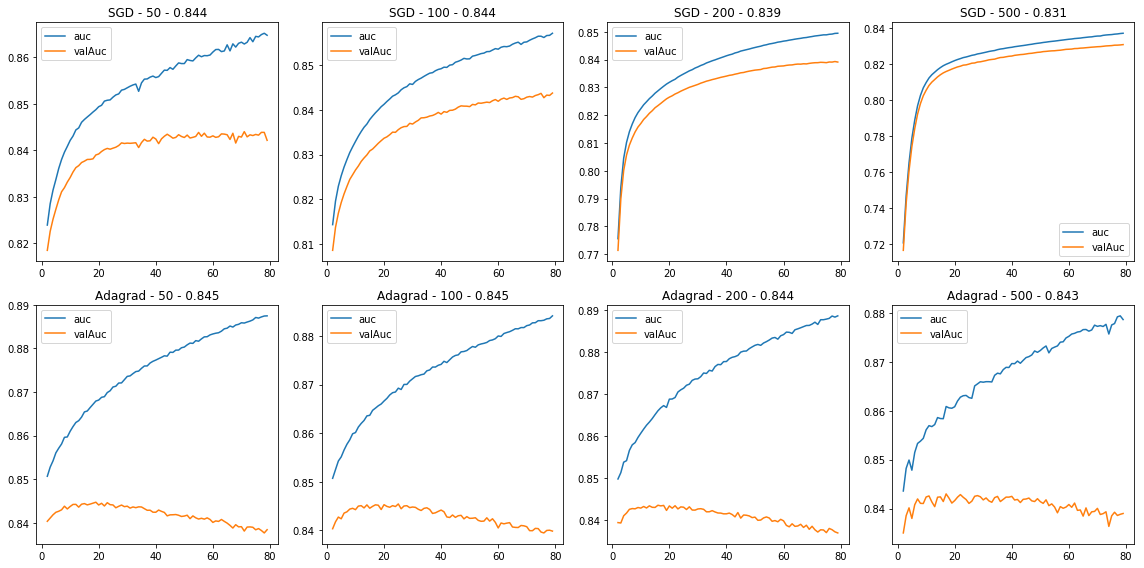

In [20]:
opti = ["SGD", "Adagrad"]
batchSizes = [50, 100, 200, 500]
test_size=0.3
X_train, X_valid = train_test_split(medical, test_size=test_size, random_state=2017, stratify=medical["UCURNINS"].values)
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for i, opt in enumerate(opti):
    for j, batch in enumerate(batchSizes):
        score, history = wrapNet(X_train, X_valid, features, 'UCURNINS', n=2, nu1=100, nu2=40, nu3=6, epochs = 80, batchSize=batch, optimizer=opt, verb=False)
        print(score)
        history = pd.DataFrame(history)
        history.iloc[2:, [1,4]].plot(ax = ax[i, j])
        ax[i, j].set_title(opt+ " - " + str(batch) + " - " + str(round(score, 3)))
        gc.collect()

plt.tight_layout()
fig.savefig("imgNets/batchSize.png")
plt.show()

## Funkcje aktywacji
Dobór odpowiedniej funkcji aktywacji jest kluczowy dla dobrze działającej sieci. Zależy nam na tym, aby funkcja aktywacji pozwoliła sieci na aproksymację dowolnych, w tym nieliniowych, zależności. Jednocześnie aproksymacja funkcji powinna być możlie łatwa, tzn nie powinna wymagać rozbudowanej sieci, gdyż potencjalnie grozi to przetrenowaniem.
![distances](img/activations.png)
Źródło: Wikipedia, https://en.wikipedia.org/wiki/Activation_function

Zobaczmy jak to wygląda w praktyce.

0.842586917819432
0.8318262973725137
0.8237782685718963
0.8462584337983372
0.8415751178100773
0.8428979232685135


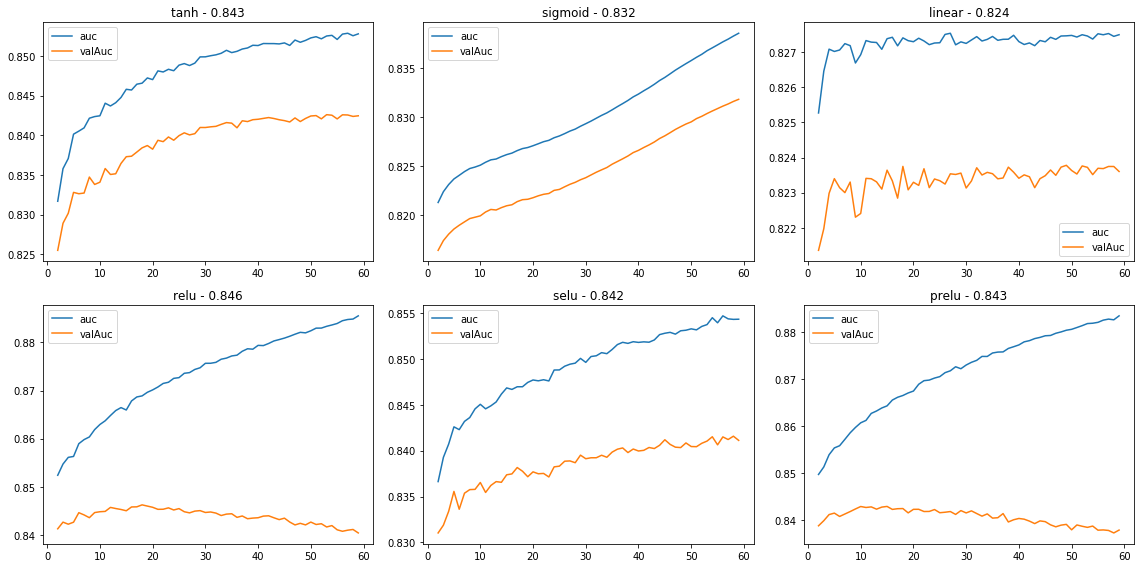

In [21]:
activations = ["tanh", "sigmoid", "linear", "relu", "selu", "prelu"]
test_size=0.3
X_train, X_valid = train_test_split(medical, test_size=test_size, random_state=2017, stratify=medical["UCURNINS"].values)
fig, ax = plt.subplots(2, 3, figsize=(16,8))
ax = ax.flatten()

for i, acti in enumerate(activations):
    score, history = wrapNet(X_train, X_valid, features, 'UCURNINS', n=2, nu1=100, nu2=40, nu3=6, epochs = 60, batchSize=100, optimizer="Adagrad", activation=acti, verb=False)
    print(score)
    history = pd.DataFrame(history)
    history.iloc[2:, [1,4]].plot(ax = ax[i])
    ax[i].set_title(str(acti)+ " - " + str(round(score, 3)))
    gc.collect()

plt.tight_layout()
fig.savefig("imgNets/activations.png")
plt.show()

## Regularyzacja
Regularyzacja może być pomocna w każdym algorytmie, w którym liczba parametrów jest wysoka.

Zwykle stosować będziemy jedną z trzech form regularyzacji, $L_1$, $L_2$ lub kombinacji $L_1$ i $L_2$.
$$R_{L_1} = \alpha \sum_{i=0}^{k} |\beta_i|$$
$$R_{L_2} = \alpha \sum_{i=0}^{k} |\beta_i|^2$$
$$R_{EN} = \alpha \sum_{i=0}^{k} [\gamma|\beta_i| + (1-\gamma)|\beta_i|^2]$$

Zwykle stosowana jest regularyzacja $L_2$, ze względu na malejące krańcowe koszty, dzięki którym pojedyncze parametry nie są zwykle redukowane do zera.

Sprawdźmy jak to zadziała w naszym problemie.

0.8450337790432536
0.8454859811854676
0.843133104924052
0.8408475382663502
0.8406673882412096
0.8374145657690104


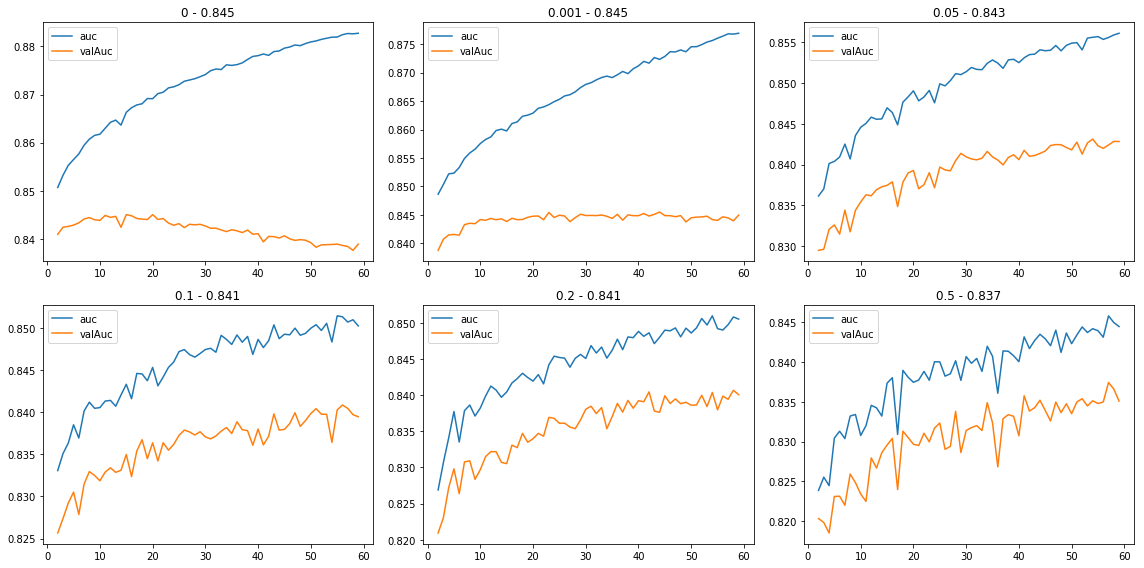

In [22]:
reguRates = [0, 0.001, 0.05, 0.1, 0.2, 0.5]
test_size=0.3
X_train, X_valid = train_test_split(medical, test_size=test_size, random_state=2017, stratify=medical["UCURNINS"].values)
fig, ax = plt.subplots(2, 3, figsize=(16,8))
ax = ax.flatten()

for i, reguRate in enumerate(reguRates):
    score, history = wrapNet(X_train, X_valid, features, 'UCURNINS', n=2, nu1=100, nu2=40, nu3=6, epochs = 60, regu=reguRate, batchSize=100, optimizer="Adagrad", verb=False)
    print(score)
    history = pd.DataFrame(history)
    history.iloc[2:, [1,4]].plot(ax = ax[i])
    ax[i].set_title(str(reguRate)+ " - " + str(round(score, 3)))
    gc.collect()

plt.tight_layout()
fig.savefig("imgNets/reguRate.png")
plt.show()

## Dropout
Inną techniką regularyzacji, która zwykle przynosi lepsze rezultaty niż regularyzacja $L_1$ czy $L_2$ jest dropout. Zasada ta polega na tym aby w trakcie trenowania sieci wyłączać (zerować) losowo wybrane neurony (połączenia).  

Ta pozornie destruktywna interwencja powoduje, że sieci zwykle lepiej uogólniają tworzony estymator. Sieć "nie może polegać" na pojedynczych połączniach, co oznacza, że najważniejsze elementy funkcji należy "przeprowadzić więcej niż jedną ścieżką". Dzięki temu dochodzi do pewnego uśrednia estymatora.

0.8454708895099333
0.8454204621195289
0.8451391649808814
0.8426862013119891
0.8413851746395538
0.8344941255744337


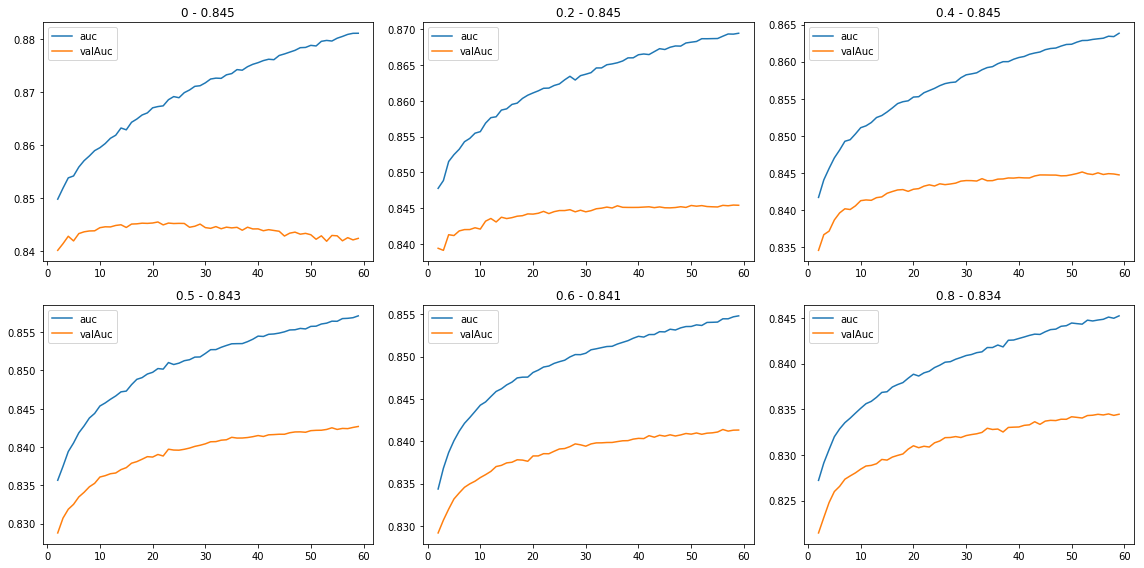

In [23]:
dropRates = [0, 0.2, 0.4, 0.5, 0.6, 0.8]
test_size=0.3
X_train, X_valid = train_test_split(medical, test_size=test_size, random_state=2017, stratify=medical["UCURNINS"].values)
fig, ax = plt.subplots(2, 3, figsize=(16,8))
ax = ax.flatten()

for i, dropRate in enumerate(dropRates):
    score, history = wrapNet(X_train, X_valid, features, 'UCURNINS', n=2, nu1=100, nu2=40, nu3=6, epochs = 60, dropout_rate=dropRate, batchSize=100, optimizer="Adagrad", verb=False)
    print(score)
    history = pd.DataFrame(history)
    history.iloc[2:, [1,4]].plot(ax = ax[i])
    ax[i].set_title(str(dropRate)+ " - " + str(round(score, 3)))
    gc.collect()

plt.tight_layout()
fig.savefig("imgNets/dropRate.png")
plt.show()

0.8445040721944831
0.845133829909143
0.843926276616892
0.8435009690828938
0.8431318990516727
0.8334720939206491


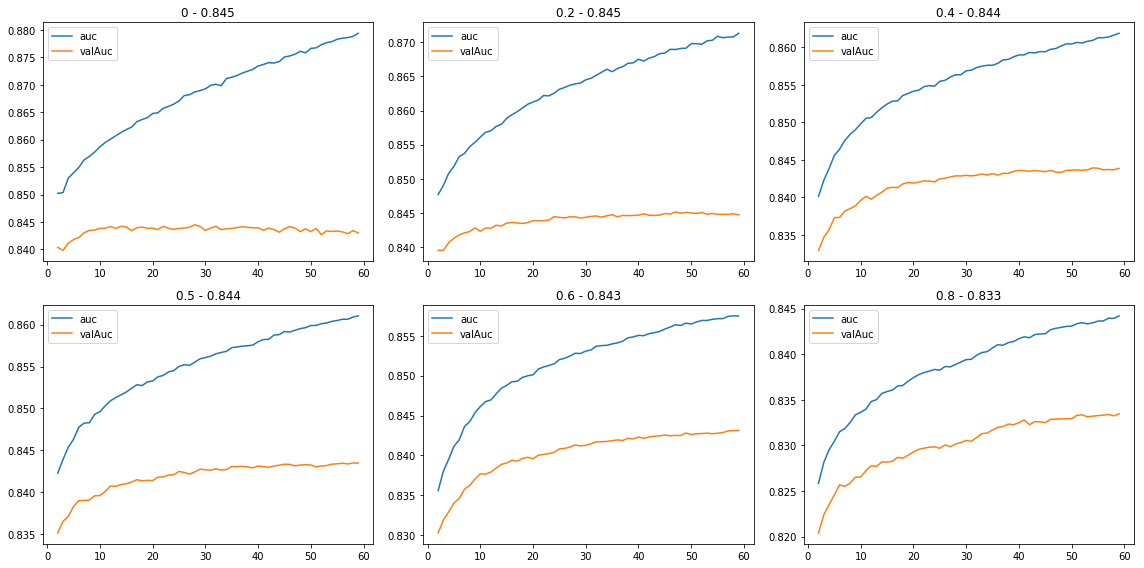

In [24]:
## uruchamiamy dla odkomentowanego dropoutu w kolejnych warstwach
dropRates = [0, 0.2, 0.4, 0.5, 0.6, 0.8]
test_size=0.3
X_train, X_valid = train_test_split(medical, test_size=test_size, random_state=2017, stratify=medical["UCURNINS"].values)
fig, ax = plt.subplots(2, 3, figsize=(16,8))
ax = ax.flatten()

for i, dropRate in enumerate(dropRates):
    score, history = wrapNet(X_train, X_valid, features, 'UCURNINS', n=2, nu1=100, nu2=40, nu3=6, epochs = 60, dropout_rate=dropRate, batchSize=100, optimizer="Adagrad", verb=False)
    print(score)
    history = pd.DataFrame(history)
    history.iloc[2:, [1,4]].plot(ax = ax[i])
    ax[i].set_title(str(dropRate)+ " - " + str(round(score, 3)))
    gc.collect()

plt.tight_layout()
fig.savefig("imgNets/dropRate2.png")
plt.show()

0.8455379067809492
0.8460335934119904
0.8448155161426116
0.845693939358505
0.8450548635390965
0.8366184707491903


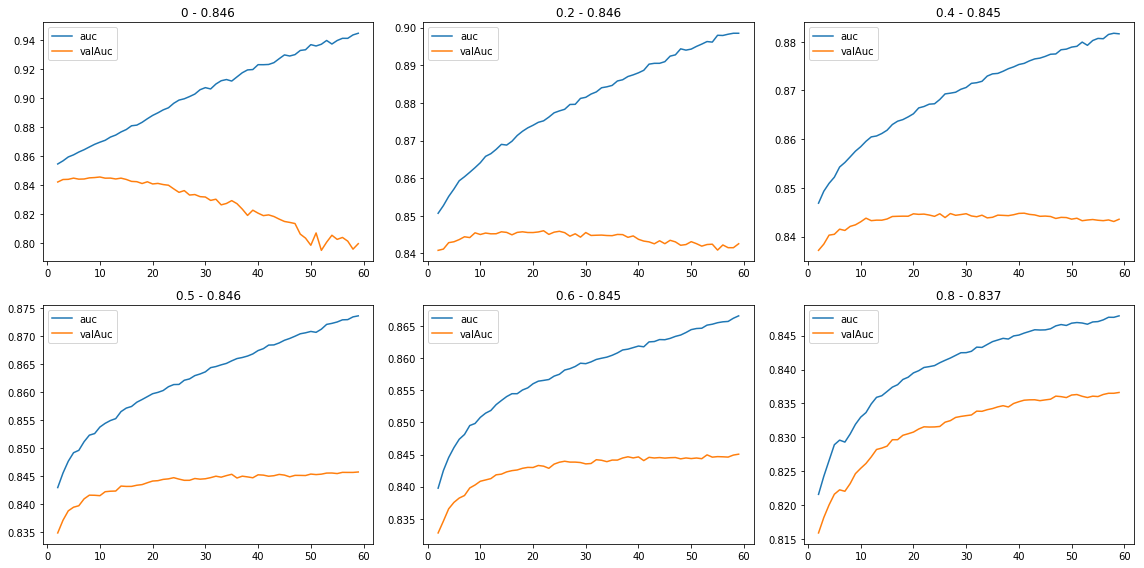

In [25]:
## uruchamiamy dla odkomentowanego dropoutu w kolejnych warstwach
dropRates = [0, 0.2, 0.4, 0.5, 0.6, 0.8]
test_size=0.3
X_train, X_valid = train_test_split(medical, test_size=test_size, random_state=2017, stratify=medical["UCURNINS"].values)
fig, ax = plt.subplots(2, 3, figsize=(16,8))
ax = ax.flatten()

for i, dropRate in enumerate(dropRates):
    score, history = wrapNet(X_train, X_valid, features, 'UCURNINS', n=3, nu1=200, nu2=100, nu3=30, epochs = 60, dropout_rate=dropRate, batchSize=100, optimizer="Adagrad", verb=False)
    print(score)
    history = pd.DataFrame(history)
    history.iloc[2:, [1,4]].plot(ax = ax[i])
    ax[i].set_title(str(dropRate)+ " - " + str(round(score, 3)))
    gc.collect()

plt.tight_layout()
fig.savefig("imgNets/dropRate3.png")
plt.show()

## Batch normaliozation
Ostatnim ważnym elementem sieci jest batch normalization. W przypadku głebokich, wielowarstwowych sieci neuronowych zdarzają się problemy "umierających gradientów". W drodze optymalizacji wynik funkcji aktywacji może przyjąć wartości, które spowodują, że drobna zmiana parametrów nie zmieni wyniku funkcji aktywacji (np dla mocno ujemnych wartości w ReLU).

Odpowiedzią na ten problem jest normalizacja wyników każdej warstwy tak aby średnia dla wszystkich obserwacji wynosiła zero.

## W praktyce na naszym zbiorze w CV mała optymalizacja
Zobaczmy jak tak naprawdę spisze się nasza sieć. Przetestujmy różne jej konfiguracjew walidacji krzyżowej.

In [ ]:
print(netFold(medical, features, 'UCURNINS', n=2, nu1=50, nu2=20, nu3=6, epochs = 60, dropout_rate=0.2, batchSize=100, optimizer="Adagrad", verb=False))
print(netFold(medical, features, 'UCURNINS', n=2, nu1=100, nu2=40, nu3=6, epochs = 60, dropout_rate=0.2, batchSize=100, optimizer="Adagrad", verb=False))
print(netFold(medical, features, 'UCURNINS', n=3, nu1=50, nu2=30, nu3=10, epochs = 60, dropout_rate=0.2, batchSize=100, optimizer="Adagrad", verb=False))
print(netFold(medical, features, 'UCURNINS', n=3, nu1=100, nu2=50, nu3=20, epochs = 60, dropout_rate=0.2, batchSize=100, optimizer="Adagrad", verb=False))

In [ ]:
print(netFold(medical, features, 'UCURNINS', n=3, nu1=200, nu2=100, nu3=40, epochs = 60, dropout_rate=0.2, batchSize=100, optimizer="Adagrad", verb=False))
print(netFold(medical, features, 'UCURNINS', n=3, nu1=400, nu2=200, nu3=40, epochs = 60, dropout_rate=0.2, batchSize=100, optimizer="Adagrad", verb=False))
print(netFold(medical, features, 'UCURNINS', n=3, nu1=100, nu2=200, nu3=40, epochs = 60, dropout_rate=0.2, batchSize=100, optimizer="Adagrad", verb=False))
print(netFold(medical, features, 'UCURNINS', n=3, nu1=100, nu2=400, nu3=40, epochs = 60, dropout_rate=0.2, batchSize=100, optimizer="Adagrad", verb=False))

[0.8484852517931236, 0.8389470461734495, 0.8531429361970438, 0.8523592563463839, 0.8382582830469355]
0.8462385547113873
[0.8477225211582988, 0.838449103497558, 0.8524137059749667, 0.8520650474016094, 0.8377976819592259]
0.8456896119983318
